In [0]:
import tensorflow as tf
from keras.layers import Input, Dense, concatenate, BatchNormalization
from keras.models import Model
from keras.datasets import cifar10
from keras.optimizers import Adam, SGD
from keras.regularizers import l1,l2
from skimage.color import rgb2gray, gray2rgb, rgb2hsv, hsv2rgb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
import threading
import multiprocessing
import math

def rgb2hsl(rgb):

    def core(_rgb, _hsl):

        irgb = _rgb.astype(np.uint16)
        ir, ig, ib = irgb[:, :, 0], irgb[:, :, 1], irgb[:, :, 2]
        h, s, l = _hsl[:, :, 0], _hsl[:, :, 1], _hsl[:, :, 2]

        imin, imax = irgb.min(2), irgb.max(2)
        iadd, isub = imax + imin, imax - imin

        ltop = (iadd != 510) * (iadd > 255)
        lbot = (iadd != 0) * (ltop == False)

        l[:] = iadd.astype(np.float) / 510

        fsub = isub.astype(np.float)
        s[ltop] = fsub[ltop] / (510 - iadd[ltop])
        s[lbot] = fsub[lbot] / iadd[lbot]

        not_same = imax != imin
        is_b_max = not_same * (imax == ib)
        not_same_not_b_max = not_same * (is_b_max == False)
        is_g_max = not_same_not_b_max * (imax == ig)
        is_r_max = not_same_not_b_max * (is_g_max == False) * (imax == ir)

        h[is_r_max] = ((0. + ig[is_r_max] - ib[is_r_max]) / isub[is_r_max])
        h[is_g_max] = ((0. + ib[is_g_max] - ir[is_g_max]) / isub[is_g_max]) + 2
        h[is_b_max] = ((0. + ir[is_b_max] - ig[is_b_max]) / isub[is_b_max]) + 4
        h[h < 0] += 6
        h[:] /= 6

    hsl = np.zeros(rgb.shape, dtype=np.float)
    cpus = multiprocessing.cpu_count()
    length = int(math.ceil(float(hsl.shape[0]) / cpus))
    line = 0
    threads = []
    while line < hsl.shape[0]:
        line_next = line + length
        thread = threading.Thread(target=core, args=(rgb[line:line_next], hsl[line:line_next]))
        thread.start()
        threads.append(thread)
        line = line_next

    for thread in threads:
        thread.join()

    return hsl

def hsl2rgb(hsl):

    def core(_hsl, _frgb):

        h, s, l = _hsl[:, :, 0], _hsl[:, :, 1], _hsl[:, :, 2]
        fr, fg, fb = _frgb[:, :, 0], _frgb[:, :, 1], _frgb[:, :, 2]

        q = np.zeros(l.shape, dtype=np.float)

        lbot = l < 0.5
        q[lbot] = l[lbot] * (1 + s[lbot])

        ltop = lbot == False
        l_ltop, s_ltop = l[ltop], s[ltop]
        q[ltop] = (l_ltop + s_ltop) - (l_ltop * s_ltop)

        p = 2 * l - q
        q_sub_p = q - p

        is_s_zero = s == 0
        l_is_s_zero = l[is_s_zero]
        per_3 = 1./3
        per_6 = 1./6
        two_per_3 = 2./3

        def calc_channel(channel, t):

            t[t < 0] += 1
            t[t > 1] -= 1
            t_lt_per_6 = t < per_6
            t_lt_half = (t_lt_per_6 == False) * (t < 0.5)
            t_lt_two_per_3 = (t_lt_half == False) * (t < two_per_3)
            t_mul_6 = t * 6

            channel[:] = p.copy()
            channel[t_lt_two_per_3] = p[t_lt_two_per_3] + q_sub_p[t_lt_two_per_3] * (4 - t_mul_6[t_lt_two_per_3])
            channel[t_lt_half] = q[t_lt_half].copy()
            channel[t_lt_per_6] = p[t_lt_per_6] + q_sub_p[t_lt_per_6] * t_mul_6[t_lt_per_6]
            channel[is_s_zero] = l_is_s_zero.copy()

        calc_channel(fr, h + per_3)
        calc_channel(fg, h.copy())
        calc_channel(fb, h - per_3)

    frgb = np.zeros(hsl.shape, dtype=np.float)
    cpus = multiprocessing.cpu_count()
    length = int(math.ceil(float(hsl.shape[0]) / cpus))
    line = 0
    threads = []
    while line < hsl.shape[0]:
        line_next = line + length
        thread = threading.Thread(target=core, args=(hsl[line:line_next], frgb[line:line_next]))
        thread.start()
        threads.append(thread)
        line = line_next

    for thread in threads:
        thread.join()

    return (frgb*255).round().astype(np.uint8)

In [0]:
# load the dataset
(x_train, _), (x_test, _) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
xtrain_temp=[]
for i in range(x_train.shape[0]):
  xtrain_temp.append(rgb2hsl(x_train[i]))

xtest_temp=[]
for i in range(x_test.shape[0]):
  xtest_temp.append(rgb2hsl(x_test[i]))

  
xtrain = np.asarray(xtrain_temp)
xtest = np.asarray(xtest_temp)
xtrain = xtrain.astype('float32')
xtest = xtest.astype('float32')


xtrain_red = xtrain[:,:,:,0]
xtrain_green = xtrain[:,:,:,1] 
xtrain_blue = xtrain[:,:,:,2]

xtest_red = xtest[:,:,:,0]
xtest_green = xtest[:,:,:,1] 
xtest_blue = xtest[:,:,:,2]

xtrain_red = xtrain_red.reshape(len(xtrain_red), np.prod(xtrain_red.shape[1:]))
xtrain_green = xtrain_green.reshape(len(xtrain_green), np.prod(xtrain_green.shape[1:]))
xtrain_blue = xtrain_blue.reshape(len(xtrain_blue), np.prod(xtrain_blue.shape[1:]))

xtest_red = xtest_red.reshape(len(xtest_red), np.prod(xtest_red.shape[1:]))
xtest_green = xtest_green.reshape(len(xtest_green), np.prod(xtest_green.shape[1:]))
xtest_blue = xtest_blue.reshape(len(xtest_blue), np.prod(xtest_blue.shape[1:]))

In [0]:
input_layer = xtrain_red.shape[1]
hid_layer1 = 576
hid_layer2 = 256
hid_layer3 = 64
hid_layer4 = 10
hid_layer5 = hid_layer3
hid_layer6 = hid_layer2
hid_layer7 = hid_layer1
output_layer = input_layer
print(xtrain_red.shape)
print(xtest_red.shape)

(50000, 1024)
(10000, 1024)


In [0]:
input_img_red = Input(shape=(input_layer,))
input_img_green = Input(shape=(input_layer,))
input_img_blue = Input(shape=(input_layer,))

W0817 11:45:57.139360 140420891531136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 11:45:57.177271 140420891531136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [0]:
# network architecture
# vanilla autoencoder with fully-connected layer
# RED
x = Dense(units = hid_layer1, activation='relu')(input_img_red)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer2, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer3, activation='relu')(x)
# x = BatchNormalization()(x)

# GREEN
y = Dense(units = hid_layer1, activation='relu')(input_img_green)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer2, activation='relu')(y)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer3, activation='relu')(y)
# y = BatchNormalization()(y)

# BLUE
z = Dense(units = hid_layer1, activation='relu')(input_img_blue)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer2, activation='relu')(z)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer3, activation='relu')(z)
# z = BatchNormalization()(z)

encoded_red = Dense(units = hid_layer4, activation='relu',kernel_regularizer = l2(3e-5), activity_regularizer = l1(10e-12))(x)
encoded_green = Dense(units = hid_layer4, activation='relu',kernel_regularizer = l2(3e-5), activity_regularizer = l1(10e-12))(y)
encoded_blue = Dense(units = hid_layer4, activation='relu',kernel_regularizer = l2(3e-5), activity_regularizer = l1(10e-12))(z)

# RED
x = Dense(units = hid_layer5, activation = 'relu')(encoded_red)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer6, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer7, activation='relu')(x)
# x = BatchNormalization()(x)

# GREEN
y = Dense(units = hid_layer5, activation = 'relu')(encoded_green)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer6, activation='relu')(y)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer7, activation='relu')(y)
# y = BatchNormalization()(y)

# BLUE
z = Dense(units = hid_layer5, activation = 'relu')(encoded_blue)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer6, activation='relu')(z)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer7, activation='relu')(z)
# z = BatchNormalization()(z)

decoded_red = Dense(units = output_layer, activation='sigmoid')(x)
decoded_green = Dense(units = output_layer, activation='sigmoid')(y)
decoded_blue = Dense(units = output_layer, activation='sigmoid')(z)

autoencoder_red = Model(input_img_red, decoded_red)
autoencoder_green = Model(input_img_green, decoded_green)
autoencoder_blue = Model(input_img_blue, decoded_blue)

encoder_red = Model(input_img_red, encoded_red)
encoder_green = Model(input_img_green, encoded_green)
encoder_blue = Model(input_img_blue, encoded_blue)

autoencoder_red.compile(optimizer= Adam(lr=1e-5), loss='mean_absolute_error')
autoencoder_green.compile(optimizer= Adam(lr=1e-5), loss='mean_absolute_error')
autoencoder_blue.compile(optimizer= Adam(lr=1e-5), loss='mean_absolute_error')

W0817 11:45:57.258262 140420891531136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0817 11:45:57.683471 140420891531136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# train the model
history_red = autoencoder_red.fit(xtrain_red, xtrain_red,
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(xtest_red, xtest_red))

W0817 11:45:58.008190 140420891531136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0817 11:45:58.255781 140420891531136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 10s 199us/step - loss: 0.2775 - val_loss: 0.2460
Epoch 2/100
50000/50000 [==============================] - 6s 120us/step - loss: 0.2234 - val_loss: 0.2080
Epoch 3/100
50000/50000 [==============================] - 6s 119us/step - loss: 0.1918 - val_loss: 0.1779
Epoch 4/100
50000/50000 [==============================] - 6s 121us/step - loss: 0.1647 - val_loss: 0.1575
Epoch 5/100
50000/50000 [==============================] - 6s 120us/step - loss: 0.1495 - val_loss: 0.1440
Epoch 6/100
50000/50000 [==============================] - 6s 120us/step - loss: 0.1407 - val_loss: 0.1397
Epoch 7/100
50000/50000 [==============================] - 6s 121us/step - loss: 0.1378 - val_loss: 0.1373
Epoch 8/100
50000/50000 [==============================] - 6s 119us/step - loss: 0.1361 - val_loss: 0.1357
Epoch 9/100
50000/50000 [==============================] - 6s 122us/step - loss: 0.1346 - val

In [0]:
# train the model
history_green = autoencoder_green.fit(xtrain_green, xtrain_green,
                                epochs=100,
                                batch_size=128,
                                shuffle=True,
                                validation_data=(xtest_green, xtest_green))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 5s 109us/step - loss: 0.2588 - val_loss: 0.2193
Epoch 2/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.2177 - val_loss: 0.2142
Epoch 3/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.2112 - val_loss: 0.2030
Epoch 4/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.1860 - val_loss: 0.1629
Epoch 5/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.1464 - val_loss: 0.1279
Epoch 6/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.1221 - val_loss: 0.1172
Epoch 7/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.1167 - val_loss: 0.1146
Epoch 8/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.1147 - val_loss: 0.1131
Epoch 9/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.1127 - val_loss: 0.

In [0]:
# train the model
history_blue = autoencoder_blue.fit(xtrain_blue, xtrain_blue,
                                epochs=100,
                                batch_size=128,
                                shuffle=True,
                                validation_data=(xtest_blue, xtest_blue))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 6s 111us/step - loss: 0.1936 - val_loss: 0.1846
Epoch 2/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.1808 - val_loss: 0.1732
Epoch 3/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.1640 - val_loss: 0.1571
Epoch 4/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.1554 - val_loss: 0.1528
Epoch 5/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.1514 - val_loss: 0.1488
Epoch 6/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.1467 - val_loss: 0.1435
Epoch 7/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.1406 - val_loss: 0.1373
Epoch 8/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.1345 - val_loss: 0.1319
Epoch 9/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.1304 - val_loss: 0.

dict_keys(['val_loss', 'loss'])


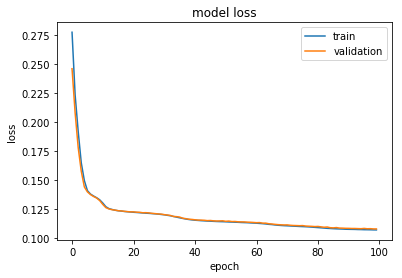

In [0]:
# list all data in history
print(history_red.history.keys())
# summarize history for loss
plt.plot(history_red.history['loss'])
plt.plot(history_red.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

dict_keys(['val_loss', 'loss'])


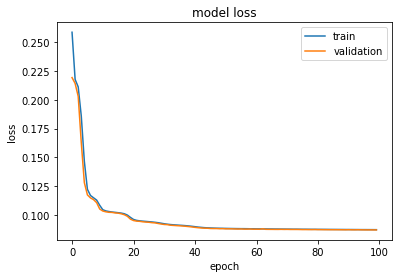

In [0]:
# list all data in history
print(history_green.history.keys())
# summarize history for loss
plt.plot(history_green.history['loss'])
plt.plot(history_green.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

dict_keys(['val_loss', 'loss'])


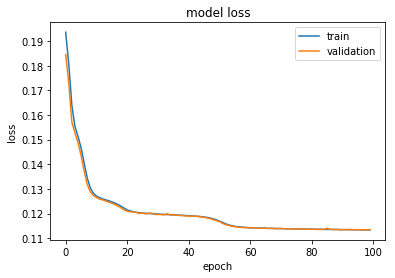

In [0]:
# list all data in history
print(history_blue.history.keys())
# summarize history for loss
plt.plot(history_blue.history['loss'])
plt.plot(history_blue.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

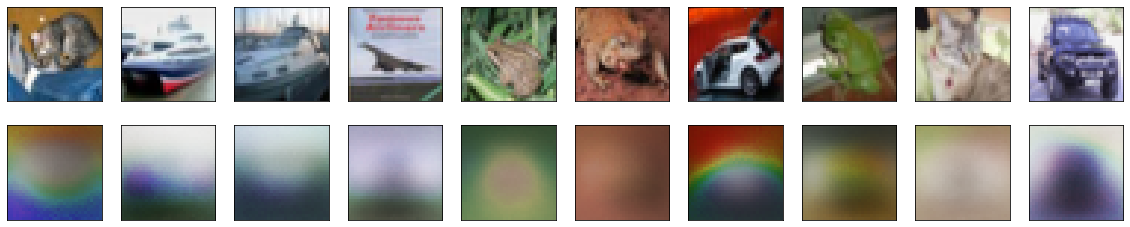

In [0]:
# show the result at the decoder output
decoded_imgs_red = autoencoder_red.predict(xtest_red)
decoded_imgs_green = autoencoder_green.predict(xtest_green)
decoded_imgs_blue = autoencoder_blue.predict(xtest_blue)

n = 10
test_imgs = np.zeros((32,32,3))
dec_imgs = np.zeros((32,32,3))

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    test_imgs[:,:,0] = xtest_red[i].reshape(32, 32)
    test_imgs[:,:,1] = xtest_green[i].reshape(32, 32)
    test_imgs[:,:,2] = xtest_blue[i].reshape(32, 32)

    plt.imshow(hsl2rgb(test_imgs))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    dec_imgs[:,:,0] = decoded_imgs_red[i].reshape(32, 32)
    dec_imgs[:,:,1] = decoded_imgs_green[i].reshape(32, 32)
    dec_imgs[:,:,2] = decoded_imgs_blue[i].reshape(32, 32)

    plt.imshow(hsl2rgb(dec_imgs))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

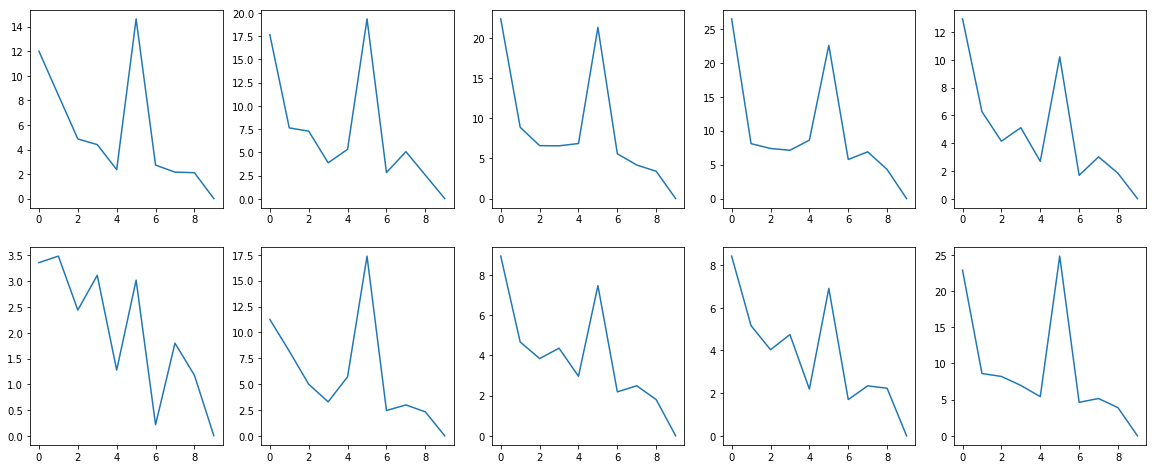

In [0]:
# show the representation at the bottleneck
encoded_imgs_red = encoder_red.predict(xtest_red)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs_red[i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

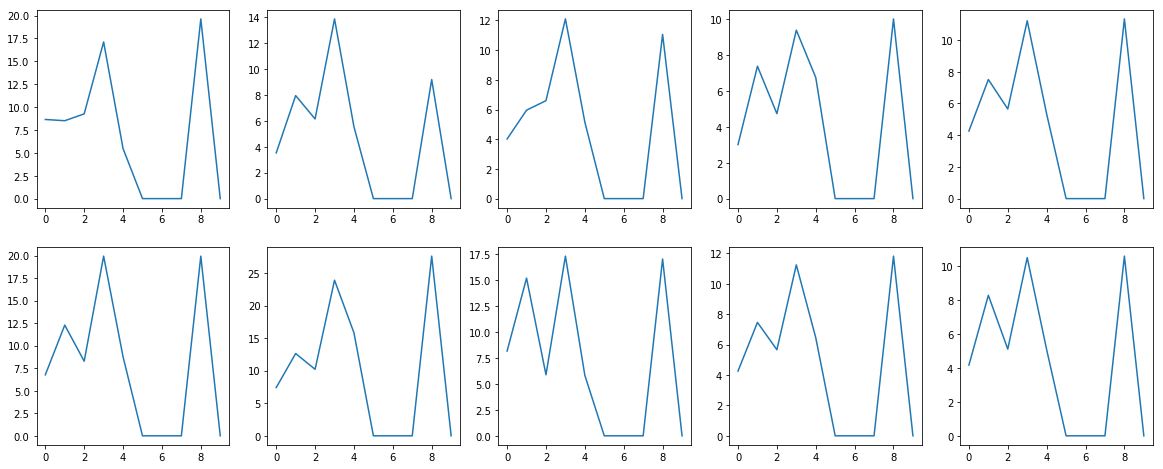

In [0]:
# show the representation at the bottleneck
encoded_imgs_green = encoder_green.predict(xtest_green)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs_green[i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

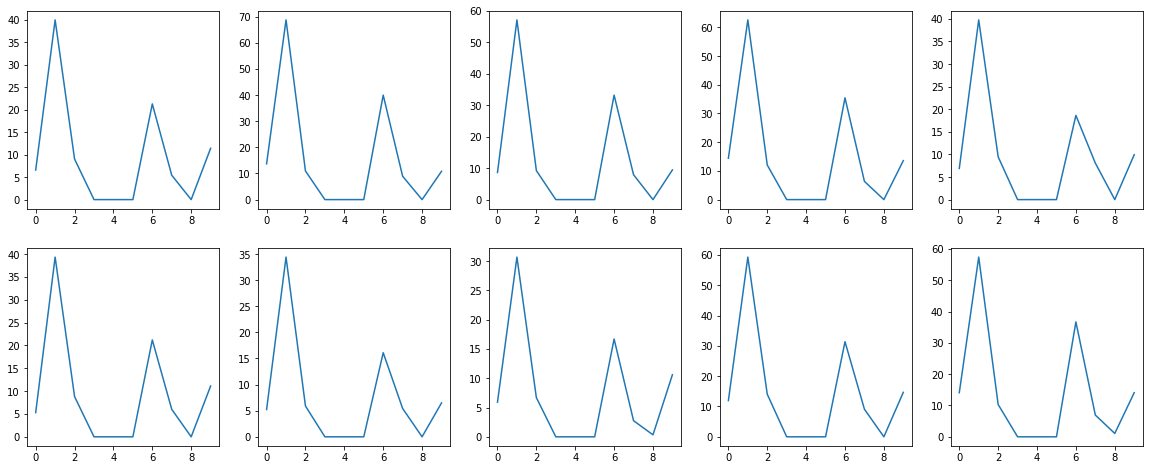

In [0]:
# show the representation at the bottleneck
encoded_imgs_blue = encoder_blue.predict(xtest_blue)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs_blue[i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

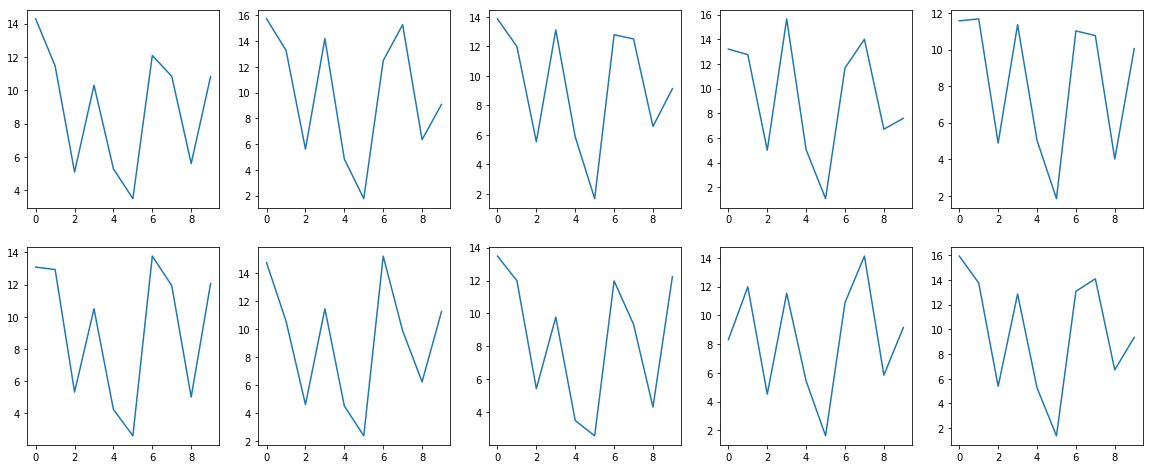

In [0]:
sum_encoded = (encoded_imgs_red + encoded_imgs_green + encoded_imgs_blue)/3.

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(sum_encoded[i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

In [0]:
autoencoder_red.save('autoencoder_baseline_hue.h5')
autoencoder_green.save('autoencoder_baseline_sat.h5')
autoencoder_blue.save('autoencoder_baseline_lum.h5')

In [0]:
from keras.models import load_model
test_model = load_model('autoencoder_baseline.h5')

encoding = Input(shape = (hid_layer4,))
# DECODER
y = Dense(units = hid_layer5, activation = 'relu')(encoding)
y = Dense(units = hid_layer6, activation='relu')(y)
y = Dense(units = hid_layer7, activation='relu')(y)

decode_avg = Dense(units = output_layer, activation='sigmoid')(y)

newModel = Model(encoding, decode_avg)
newModel.summary()
newModel.layers[1].set_weights(test_model.layers[5].get_weights())
newModel.layers[2].set_weights(test_model.layers[6].get_weights())
newModel.layers[3].set_weights(test_model.layers[7].get_weights())
newModel.layers[4].set_weights(test_model.layers[8].get_weights())

In [0]:
# show the result at the decoder output
decoded_imgs = newModel.predict(avg_bottleneck)

n = 10
test_imgs = np.zeros((32,32,3))

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    test_imgs[:,:,0] = xtest_red[counter + i].reshape(32, 32)
    test_imgs[:,:,1] = xtest_green[counter + i].reshape(32, 32)
    test_imgs[:,:,2] = xtest_blue[counter + i].reshape(32, 32)

    plt.imshow(test_imgs)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[counter + i].reshape(32,32))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()